# Loading images

In [1]:
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

from torch.utils.data import Dataset, DataLoader,TensorDataset
from torchvision import transforms

from torchsummary import summary
%matplotlib inline

In [2]:
%%time
#labels with the same order
train_images = []
train_labels = []

test_images = []
test_dict = {}
train_filenames = []
test_filenames = []


labels_df = pd.read_csv('train_onelabel.csv')
labels_dict = labels_df.set_index('image')['class'].to_dict()

for filename in labels_df['image'].values: ##to keep mapping with classes
    train_images.append(Image.open('train_images/'+filename).copy())
    train_labels.append(labels_dict[filename])
    train_filenames.append(filename)
for filename in glob.iglob('test_images' +'/*'):
    image = Image.open(filename).copy()
    test_images.append(image)
    test_filenames.append(filename.replace('test_images/', ''))

CPU times: user 9.62 s, sys: 1.61 s, total: 11.2 s
Wall time: 18.1 s


Average width 73.32110394976037 , Average height: 66.46897207073211


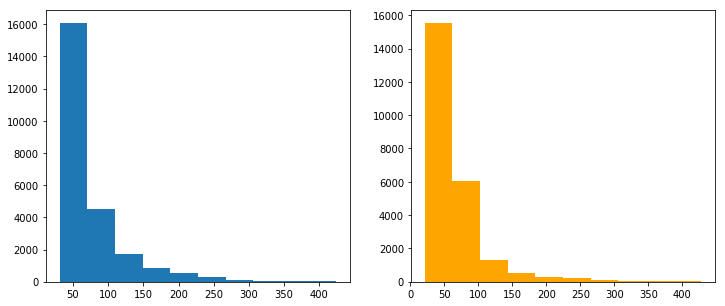

In [3]:
#PIL

widths, heights = [], [] 
sumx, sumy = 0, 0
for i in train_images:
    sumx += i.size[0]
    widths.append(i.size[0])
    sumy += i.size[1]
    heights.append(i.size[1])


fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(widths)
ax2.hist(heights, color = 'orange')
fig.set_size_inches(12, 5)

avg_width = np.mean(widths)
avg_height = np.mean(heights)
print('Average width {} , Average height: {}'.format(avg_width, avg_height))

In [4]:
class ListsTrainDataset(Dataset):
    def __init__(self, list_of_images, list_of_labels, transform=None):
        """
        Args:
            csv_path (string): path to csv file
            height (int): image height
            width (int): image width
            transform: pytorch transforms for transforms and tensor conversion
        """
#         super().__init__()
        self.data = list_of_images
        self.labels = np.asarray(list_of_labels).reshape(-1,1)
        self.transform = transform

    def __getitem__(self, index):
        single_image = self.data[index]
        single_image_label = self.labels[index]
        # Transform image to tensor
        if self.transform is not None:
            img_as_tensor = self.transform(single_image)
        # Return image and the label
        return (img_as_tensor, single_image_label)

    def __len__(self):
        return len(self.data)

In [5]:
class ListsTestDataset(Dataset):
    def __init__(self, list_of_images, transform=None):
        """
        Args:
            csv_path (string): path to csv file
            height (int): image height
            width (int): image width
            transform: pytorch transforms for transforms and tensor conversion
        """
        self.data = list_of_images
        self.transform = transform

    def __getitem__(self, index):
        single_image = self.data[index]
        if self.transform is not None:
            img_as_tensor = self.transform(single_image)
        # Return image ONLY
        return img_as_tensor

    def __len__(self):
        return len(self.data)

In [6]:
#Transforms and Dataset Creation
def create_datasets_dataloaders(X_train, y_train, X_test= None, y_test = None):
    test_transforms = transforms. Compose([
        transforms.CenterCrop(64),
        transforms.ToTensor()
    ])
    train_transforms = transforms. Compose([
        transforms.CenterCrop(64),
        transforms.ToTensor()
    ])
    
    train_dataset = ListsTrainDataset(X_train, y_train, transform = train_transforms)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True, num_workers=2)

    if y_test is not None:
        test_dataset = ListsTrainDataset(X_test, y_test, transform = test_transforms)
    else:
        test_dataset = ListsTestDataset(X_test, transform = test_transforms)

    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 100, shuffle = False)
    return (train_loader, test_loader)

In [7]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(50, 20, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer3 = nn.Sequential(
            Flatten(),
            nn.Linear(20*7*7, 250),
            nn.ReLU())
        self.fc = nn.Linear(250, 121)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.fc(out)
        return out

In [8]:
from torchvision.models.resnet import BasicBlock, Bottleneck, ResNet
import math

In [9]:
class ResNetMine(nn.Module):

    def __init__(self, block, layers, num_classes=121):
        self.inplanes = 64
        super(ResNetMine, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(3, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [13]:
def train(model, data_loader, num_epochs):
    learning_rate = 0.0001
    batch_size = data_loader.batch_size
    criterion = nn.CrossEntropyLoss();
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);
#     optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate);
    #Training
    history = {'batch': [], 'loss': [], 'accuracy': []}
    for epoch in range(num_epochs):
            for i, (images, labels) in enumerate(data_loader):
                images = Variable(images).cuda()
                labels = Variable(labels).squeeze(1).long().cuda()#.cpu()
                # Forward + Backward + Optimize
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                _, argmax = torch.max(outputs, 1)
                accuracy_train = (labels == argmax.squeeze()).float().mean()*100
                # Show progress
                if (i+1) % 32 == 0:
                    log = " ".join([
                      "Epoch : %d/%d" % (epoch+1, num_epochs),
                      "Iter : %d/%d" % (i+1, len(data_loader.dataset)//batch_size),
                      "Loss: %.4f" % loss.item(),
                      "Accuracy: %.4f" % accuracy_train])
                    print('\r{}'.format(log), end='')
                    history['batch'].append(i)
                    history['loss'].append(loss.item())
                    history['accuracy'].append(accuracy_train.item())
            print()
    return model

In [ ]:
cnn.eval().cuda()
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images)
    labels= labels.squeeze(1)
    outputs = cnn(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted.float() == labels).sum()
print('Test Accuracy of the model on the 60000 test images: %.4f %%' % (100*correct.item() / total))

In [29]:
def predict_test_set(model, loader, filenames):
    predictions = []
    for images in loader:
        images = Variable(images).cuda()
        outputs = model(images)
        _, prediction = torch.max(outputs.data, 1)
        predictions.extend(prediction.cpu().numpy())
    results_df = pd.DataFrame({'image': test_filenames, 'class': predictions}, columns=['image', 'class'])
    results_df.to_csv('results.csv',sep = ',', index = False)

In [18]:
train_loader, test_loader = create_datasets_dataloaders(train_images, train_labels)
cnn = ResNetMine(Bottleneck, [1, 1, 1, 1]).cuda()
trained_model = train(cnn, train_loader, num_epochs=20)

Epoch : 1/20 Iter : 736/756 Loss: 2.3699 Accuracy: 37.5000
Epoch : 2/20 Iter : 736/756 Loss: 1.3930 Accuracy: 68.7500
Epoch : 3/20 Iter : 736/756 Loss: 1.4569 Accuracy: 62.5000
Epoch : 4/20 Iter : 736/756 Loss: 1.5544 Accuracy: 56.2500
Epoch : 5/20 Iter : 736/756 Loss: 1.6526 Accuracy: 56.2500
Epoch : 6/20 Iter : 736/756 Loss: 0.8762 Accuracy: 71.8750
Epoch : 7/20 Iter : 736/756 Loss: 0.4489 Accuracy: 90.62500
Epoch : 8/20 Iter : 736/756 Loss: 0.5242 Accuracy: 81.2500
Epoch : 9/20 Iter : 736/756 Loss: 0.1570 Accuracy: 100.0000
Epoch : 10/20 Iter : 736/756 Loss: 0.1374 Accuracy: 96.87500
Epoch : 11/20 Iter : 736/756 Loss: 0.0787 Accuracy: 96.87500
Epoch : 12/20 Iter : 736/756 Loss: 0.1741 Accuracy: 96.87500
Epoch : 13/20 Iter : 736/756 Loss: 0.0977 Accuracy: 93.75000
Epoch : 14/20 Iter : 736/756 Loss: 0.0242 Accuracy: 100.0000
Epoch : 15/20 Iter : 736/756 Loss: 0.0554 Accuracy: 100.0000
Epoch : 16/20 Iter : 736/756 Loss: 0.0896 Accuracy: 100.0000
Epoch : 17/20 Iter : 736/756 Loss: 0.055

In [30]:
##predict on testset

test_transforms = transforms. Compose([
        transforms.CenterCrop(64),
        transforms.ToTensor()
    ])

test_dataset = ListsTestDataset(test_images, transform = test_transforms)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 100, shuffle = False)

predict_test_set(trained_model, test_loader, test_filenames)

## KFolds

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, random_state=None, shuffle=True)
trained_models = []
for train_indexes, validation_indexes in kf.split(train_images):
    X_train = []
    y_train = []
    X_val = []
    y_val = []
    
    for i in train_indexes:
        X_train.append(train_images[i])
        y_train.append(train_labels[i])
    for j in validation_indexes:
        X_val.append(train_images[j])
        y_val.append(train_labels[j])
    train_loader, test_loader = create_datasets_dataloaders(
        X_train, y_train, X_val, y_val)
    
    #Training
    cnn = ResNetMine(Bottleneck, [2, 2, 2, 2]).cuda()
#     print(summary(cnn, (1,28,28)))
    trained_model = train(cnn, train_loader, num_epochs=100)
    trained_models.append(trained_model)

In [40]:
cnn2 = trained_models[1]
cnn2.fc.weight

Parameter containing:
tensor([[ 0.0070,  0.0135,  0.0011,  ..., -0.0310, -0.0125, -0.0374],
        [ 0.0209, -0.0459,  0.0046,  ...,  0.0476,  0.0577,  0.0305],
        [-0.0291,  0.0265,  0.0575,  ...,  0.0408,  0.0601,  0.0046],
        ...,
        [-0.0418, -0.0169,  0.0464,  ..., -0.0072,  0.0393, -0.0152],
        [ 0.0230,  0.0071,  0.0051,  ..., -0.0624,  0.0516, -0.0562],
        [-0.0260, -0.0319,  0.0064,  ...,  0.0367,  0.0147,  0.0346]],
       device='cuda:0', requires_grad=True)